# GRU Classifier

In [2]:
%load_ext autoreload
%autoreload 2

In [ ]:
import sys
import time
import random
import json

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import sentencepiece as spm
from sklearn.model_selection import train_test_split
from sklearn.metrics import jaccard_score
from torcheval.metrics.functional import (
    multilabel_accuracy,
    multilabel_precision_recall_curve,
)
from tqdm import tqdm
import matplotlib.pyplot as plt

sys.path.append("scripts")
from scripts.steam_review_dataset import SteamReviewDataset
from scripts.annotations import update_df_review_labels

In [4]:
device = torch.device(
    "cuda"
    if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available() else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [5]:
seed = 1234

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True

In [6]:
# Lade die Daten
df = pd.read_csv("../data/reviews_100k_cleaned_new.csv.bz2")

# Lade labels
llm_notation_file = (
    "./scripts/results/annotations-v3-2025-02-14T17_38_08.995970-n2000-llama3.2.json"
)

with open(llm_notation_file, "r") as fi:
    review_id_with_topics = {
        int(k): v for k, v in json.load(fi).items()
    }  # str keys to int

df, topics = update_df_review_labels(df, review_id_with_topics, dropna=True)

print(f"Found {len(topics)} topics: {topics}\n")
print(df.info())
print("\nTopic distribution:")
print(df.iloc[:, -12:].sum())

Found 12 topics: ['visuals', 'online_play', 'updates', 'price', 'bugs', 'story', 'seasonal_content', 'support', 'gamemode', 'sound', 'gameplay', 'hardware_requirements']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   review_id              2000 non-null   int64  
 1   review                 2000 non-null   object 
 2   voted_up               2000 non-null   bool   
 3   votes_up               2000 non-null   int64  
 4   weighted_vote_score    2000 non-null   float64
 5   app_id                 2000 non-null   int64  
 6   visuals                2000 non-null   float64
 7   online_play            2000 non-null   float64
 8   updates                2000 non-null   float64
 9   price                  2000 non-null   float64
 10  bugs                   2000 non-null   float64
 11  story                  2000 non-null   fl

In [7]:
# Aufteilen in Train+Validation und Test (80/20 Split)
train_val_df, test_df = train_test_split(
    df,
    test_size=0.2,
    random_state=42,  # TODO stratify causes issues with multilabel targets
)

# Aufteilen von Train+Validation in Training und Validation (75/25 von Train+Val)
train_df, val_df = train_test_split(train_val_df, test_size=0.25, random_state=42)

# Überprüfe die Größe der Splits
print(f"Original size: {len(df)}")
print(f"Train size: {len(train_df)}")
print(f"Validation size: {len(val_df)}")
print(f"Test size: {len(test_df)}")

Original size: 2000
Train size: 1200
Validation size: 400
Test size: 400


In [8]:
# Erstelle Dataset-Objekte
tokenizer = spm.SentencePieceProcessor(model_file="../data/reviews_unigram.model")
max_len = 200  # 91% der Reviews haben weniger als 200 Tokens
batch_size = 16

train_dataset = SteamReviewDataset(
    data=train_df,
    tokenizer=tokenizer,
    max_len=max_len,
    topic_mode=True,
    topics=topics,
)
val_dataset = SteamReviewDataset(
    data=val_df,
    tokenizer=tokenizer,
    max_len=max_len,
    topic_mode=True,
    topics=topics,
)
test_dataset = SteamReviewDataset(
    data=test_df,
    tokenizer=tokenizer,
    max_len=max_len,
    topic_mode=True,
    topics=topics,
)

# Erstelle DataLoader für jeden Split
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Batch Shape
for tokens, topics_onehot in train_loader:
    print(f"Tokens shape: {tokens.shape}, Labels shape: {topics_onehot.shape}")
    break

print(train_dataset[0])

Tokens shape: torch.Size([16, 200]), Labels shape: torch.Size([16, 12])
(tensor([ 508,  185,  104,   76,   28, 1355,  989,  391,    4, 1531, 1628, 1124,
        1036,   22,  105, 1140,    4,  186,    5,   31,    9, 2941,   12,    4,
         162, 2434,    6, 1521,  325,    6,    4,  958,  162,  368,    7, 2118,
        2125,  109,    6,  109,    6,  109,  177,  105, 1140,  423,   25,  256,
          16,  190, 3867,  186,  238,   19,  289,   76,   28,   41, 1052,   11,
          58,  274,    4,   34,   36,   13,  127,  423,  144,   16, 3090,   29,
          35,  542,   12,  347,  111, 3529,    5,  560,   38,    4,  186, 1739,
          44, 3246,   63,    6, 1426,  105,   13,   43,   70,   14,    4,   78,
           5, 2766,   47,  118,    6,   57,   12,    4,  186, 1609, 3084,  673,
          60,  430,  161,   89, 1360,   48,    4,   95,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    

In [9]:
class GRUClassifier(nn.Module):
    def __init__(
        self,
        vocab_size: int,
        embedding_dim: int,
        gru_layers: int,
        hidden_dim: int,
        dropout: float,
        output_dim: int,
        pad_idx: int,
    ):
        super(GRUClassifier, self).__init__()
        self.embedding = nn.Embedding(
            num_embeddings=vocab_size, embedding_dim=embedding_dim, padding_idx=pad_idx
        )
        self.gru = nn.GRU(
            input_size=embedding_dim,
            num_layers=gru_layers,
            hidden_size=hidden_dim,
            dropout=dropout if gru_layers > 1 else 0,
            batch_first=True,
        )
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # x: (batch_size, seq_length)

        embedded = self.embedding(x)  # (batch_size, seq_length, embedding_dim)

        gru_out, _ = self.gru(embedded)  # (batch_size, seq_length, hidden_dim)

        last_hidden_state = gru_out[:, -1, :]  # (batch_size, hidden_dim)

        output = self.fc(last_hidden_state)  # (batch_size, output_dim)

        return output

In [10]:
def train_model(
    model: GRUClassifier,
    train_loader: DataLoader,
    val_loader: DataLoader,
    epochs: int,
    lr: float,
    device=torch.device("cpu"),
):
    # Loss und Optimizer definieren
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4, fused=False)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="min", factor=0.1, patience=1
    )

    model.to(device)

    print(f"Start training on device '{device}'")

    # Early Stopping Parameter
    patience = 5
    patience_counter = 0
    best_val_accuracy = 0.0
    best_model_state = None
    last_epoch = 0

    # Listen für Visualisierung
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    # Training und Validation Loop
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        train_labels = []
        train_preds = []

        train_progress = tqdm(
            train_loader, desc=f"Epoch [{epoch+1}/{epochs}]", ncols=100
        )

        epoch_start_time = time.time()  # Startzeit für die Epoche

        # Trainingsloop
        for batch in train_progress:
            tokens, topics_onehot = batch

            tokens, topics_onehot = tokens.to(device), topics_onehot.to(device)

            # Forward Pass
            optimizer.zero_grad()
            outputs = model(tokens)

            loss = criterion(outputs, topics_onehot)

            # Backward Pass und Optimierung
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            running_loss += loss.item()

            # Berechne Predictions und füge sie zur Liste hinzu
            probabilities = torch.sigmoid(outputs)
            threshold = 0.5
            train_preds += (probabilities >= threshold).cpu().int().numpy().tolist()
            train_labels += topics_onehot.cpu().int().numpy().tolist()

            # Update TQDM mit dem aktuellen Loss
            train_progress.set_postfix(
                loss=f"{running_loss / (train_progress.n + 1):.3f}"
            )

        # Berechne Trainings-Accuracy
        train_accuracy = jaccard_score(
            train_labels, train_preds, average="samples", zero_division=1
        )

        train_losses.append(running_loss / len(train_loader))
        train_accuracies.append(train_accuracy)

        # Validierung
        model.eval()
        val_loss = 0.0
        val_labels = []
        val_preds = []

        with torch.no_grad():
            for batch in val_loader:
                tokens, topics_onehot = batch
                tokens, topics_onehot = tokens.to(device), topics_onehot.to(device)

                outputs = model(tokens)
                loss = criterion(outputs.squeeze(), topics_onehot)
                val_loss += loss.item()

                probabilities = torch.sigmoid(outputs)
                threshold = 0.5
                val_preds += (probabilities >= threshold).cpu().int().numpy().tolist()
                val_labels += topics_onehot.cpu().int().numpy().tolist()

        scheduler.step(val_loss)  # Scheduler mit Validierungs-Loss aufrufen

        # Berechne Validierungs-Accuracy
        val_accuracy = jaccard_score(
            val_labels, val_preds, average="samples", zero_division=1
        )

        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(val_accuracy)

        epoch_end_time = time.time()
        epoch_duration = epoch_end_time - epoch_start_time
        mins, secs = divmod(epoch_duration, 60)

        print(
            "├ "
            f"Train Loss: {running_loss/len(train_loader):.4f}, "
            f"Train Accuracy: {train_accuracy:.4f}, "
            f"Validation Loss: {val_loss/len(val_loader):.4f}, "
            f"Validation Accuracy: {val_accuracy:.4f}, "
            f"Time: {int(mins):2}:{secs:.2f}m"
        )

        # Early Stopping Überprüfung
        if val_accuracy > best_val_accuracy:
            print(
                f"└ Validation accuracy improved: {best_val_accuracy:.4f} → {val_accuracy:.4f}"
            )
            best_val_accuracy = val_accuracy
            patience_counter = 0
            best_model_state = model.state_dict()  # Speichere das beste Modell
            last_epoch = epoch
        else:
            patience_counter += 1
            print(
                f"└ No improvement in validation accuracy. "
                f"Patience counter: {patience_counter}/{patience}. Using LR: {scheduler.get_last_lr()[0]:.1e}",
            )
            # Überprüfe, ob Early Stopping ausgelöst werden soll
            if patience_counter >= patience:
                print(
                    "Early stopping triggered! "
                    f"Best Validation Accuracy: {best_val_accuracy:.2f}, on epoch {last_epoch+1}"
                )
                break

    # Lade das beste Modell zurück, falls Early Stopping ausgelöst wurde
    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    print(
        f"Finished Training: Best Validation Accuracy: {best_val_accuracy:.2f}, on epoch {last_epoch+1}"
    )

    return model, train_losses, val_losses, train_accuracies, val_accuracies, last_epoch

In [11]:
# Lade den Tokenizer, um `vocab_size` und `pad_id` zu erhalten
tokenizer = spm.SentencePieceProcessor(model_file="../data/reviews_unigram.model")
vocab_size = tokenizer.get_piece_size()
pad_idx = tokenizer.pad_id()

# Modellparameter
embedding_dim = 512
gru_layers = 2
hidden_dim = 1024
output_dim = len(topics)
dropout = 0.5

# Initialisiere das GRU-Modell
model = GRUClassifier(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    gru_layers=gru_layers,
    hidden_dim=hidden_dim,
    dropout=dropout,
    output_dim=output_dim,
    pad_idx=pad_idx,
)
print(model)

GRUClassifier(
  (embedding): Embedding(4000, 512, padding_idx=0)
  (gru): GRU(512, 1024, num_layers=2, batch_first=True, dropout=0.5)
  (fc): Linear(in_features=1024, out_features=12, bias=True)
)


In [ ]:
# Trainiere das Modell
epochs = 100
lr = 0.001

(
    trained_model,
    train_losses,
    val_losses,
    train_accuracies,
    val_accuracies,
    last_epoch,
) = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=epochs,
    lr=lr,
    device=device,
)

# alterniiv: Model laden
# model.load_state_dict(torch.load("../models/gru_topics_classifier.pth"))

Start training on device 'cuda'


Epoch [1/100]: 100%|████████████████████████████████████| 75/75 [00:04<00:00, 17.00it/s, loss=0.467]


├ Train Loss: 0.4604, Train Accuracy: 0.2805, Validation Loss: 0.4431, Validation Accuracy: 0.3026, Time:  0:5.03m
└ Validation accuracy improved: 0.0000 → 0.3026


Epoch [2/100]: 100%|████████████████████████████████████| 75/75 [00:04<00:00, 18.31it/s, loss=0.430]


├ Train Loss: 0.4299, Train Accuracy: 0.2910, Validation Loss: 0.4506, Validation Accuracy: 0.3094, Time:  0:4.73m
└ Validation accuracy improved: 0.3026 → 0.3094


Epoch [3/100]: 100%|████████████████████████████████████| 75/75 [00:04<00:00, 18.23it/s, loss=0.410]


├ Train Loss: 0.4097, Train Accuracy: 0.3247, Validation Loss: 0.4506, Validation Accuracy: 0.3068, Time:  0:4.73m
└ No improvement in validation accuracy. Patience counter: 1/5. Using LR: 1.0e-04


Epoch [4/100]: 100%|████████████████████████████████████| 75/75 [00:04<00:00, 18.19it/s, loss=0.379]


├ Train Loss: 0.3793, Train Accuracy: 0.3570, Validation Loss: 0.4462, Validation Accuracy: 0.3043, Time:  0:4.74m
└ No improvement in validation accuracy. Patience counter: 2/5. Using LR: 1.0e-04


Epoch [5/100]: 100%|████████████████████████████████████| 75/75 [00:04<00:00, 18.30it/s, loss=0.363]


├ Train Loss: 0.3634, Train Accuracy: 0.3686, Validation Loss: 0.4453, Validation Accuracy: 0.2634, Time:  0:4.71m
└ No improvement in validation accuracy. Patience counter: 3/5. Using LR: 1.0e-05


Epoch [6/100]: 100%|████████████████████████████████████| 75/75 [00:04<00:00, 18.25it/s, loss=0.352]


├ Train Loss: 0.3520, Train Accuracy: 0.3646, Validation Loss: 0.4451, Validation Accuracy: 0.2683, Time:  0:4.73m
└ No improvement in validation accuracy. Patience counter: 4/5. Using LR: 1.0e-05


Epoch [7/100]: 100%|████████████████████████████████████| 75/75 [00:04<00:00, 18.16it/s, loss=0.350]


├ Train Loss: 0.3497, Train Accuracy: 0.3736, Validation Loss: 0.4452, Validation Accuracy: 0.2720, Time:  0:4.75m
└ No improvement in validation accuracy. Patience counter: 5/5. Using LR: 1.0e-06
Early stopping triggered! Best Validation Accuracy: 0.31, on epoch 2
Finished Training: Best Validation Accuracy: 0.31, on epoch 2


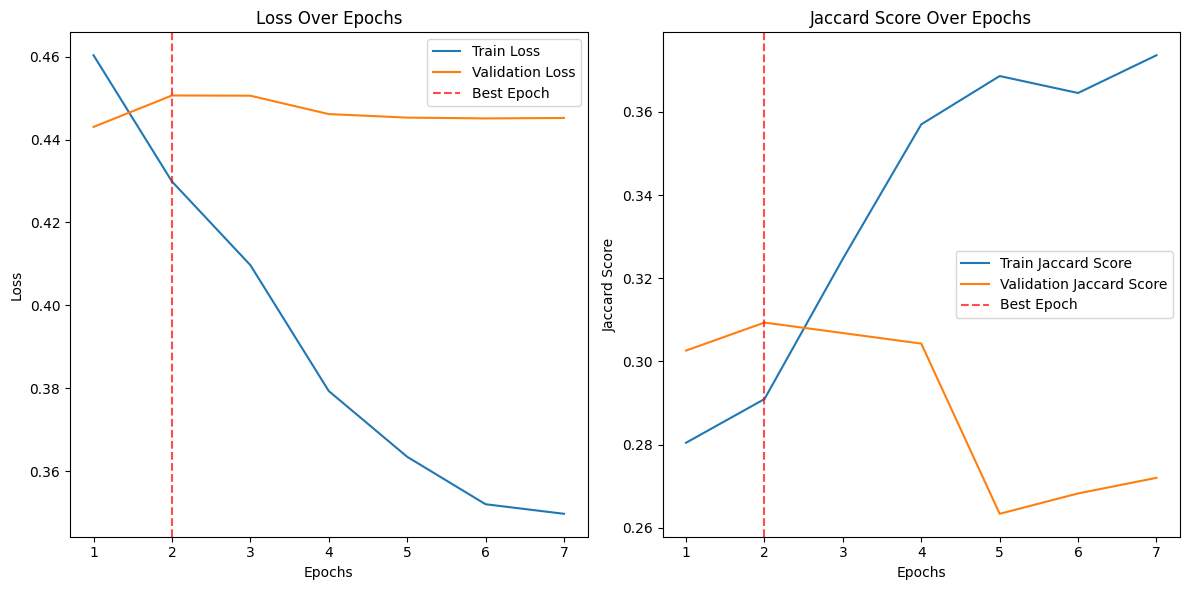

In [18]:
def plot_results(
    train_losses, val_losses, train_accuracies, val_accuracies, last_epoch
):

    epochs = range(1, len(train_losses) + 1)

    # Loss Plot
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label="Train Loss")
    plt.plot(epochs, val_losses, label="Validation Loss")
    plt.axvline(
        x=last_epoch + 1,
        color="r",
        linestyle="--",
        label=f"Best Epoch",
        alpha=0.7,
    )
    plt.xticks(range(1, len(epochs) + 1))
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss Over Epochs")
    plt.legend()

    # Accuracy Plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label="Train Jaccard Score")
    plt.plot(epochs, val_accuracies, label="Validation Jaccard Score")
    plt.axvline(
        x=last_epoch + 1,
        color="r",
        linestyle="--",
        label=f"Best Epoch",
        alpha=0.7,
    )
    plt.xticks(range(1, len(epochs) + 1))
    plt.xlabel("Epochs")
    plt.ylabel("Jaccard Score")
    plt.title("Jaccard Score Over Epochs")
    plt.legend()
    # Add vertical line at specific x value

    # Anzeigen
    plt.tight_layout()
    plt.show()


plot_results(train_losses, val_losses, train_accuracies, val_accuracies, last_epoch)

In [14]:
# Funktion zum Testen des Modells mit zusätzlichen Metriken
def evaluate_model(model, test_loader):
    model.eval()  # Setze das Modell in den Eval-Modus
    test_loss = 0.0
    test_labels = []
    test_preds = []

    criterion = nn.BCEWithLogitsLoss()

    with torch.no_grad():  # Keine Gradientenberechnung für Test
        for batch in test_loader:
            tokens, labels = batch
            tokens, labels = tokens.to(device), labels.to(device)

            # Forward Pass
            outputs = model(tokens)
            loss = criterion(outputs.squeeze(), labels)
            test_loss += loss.item()

            probabilities = torch.sigmoid(outputs)
            threshold = 0.5
            test_preds += (probabilities >= threshold).cpu().int().numpy().tolist()
            test_labels += topics_onehot.cpu().int().numpy().tolist()

    # Berechne Metriken
    test_accuracy = jaccard_score(
        test_labels, test_preds, average="samples", zero_division=1
    )
    prec_recall = multilabel_precision_recall_curve(
        torch.tensor(test_preds), torch.tensor(test_labels), num_labels=len(topics)
    )
    # Ausgabe der Metriken
    print(f"Test Loss: {test_loss/len(test_loader):.4f}")
    # print(f"Test Accuracy: {test_accuracy:.4f}")
    # print(f"Test PrecRec: {prec_recall}")

    print(
        f"Jaccard Samples 0: {jaccard_score(test_labels, test_preds, average="samples", zero_division=0):.4f}"
    )
    print(
        f"Jaccard Samples 1: {jaccard_score(test_labels, test_preds, average="samples", zero_division=1):.4f}"
    )
    print(
        f"Jaccard Micro: {jaccard_score(test_labels, test_preds, average="micro", zero_division=1):.4f}"
    )
    print(
        f"Jaccard Macro: {jaccard_score(test_labels, test_preds, average="macro", zero_division=1):.4f}"
    )
    print(
        f"Multilabel Accurcy: {multilabel_accuracy(
            torch.tensor(test_preds),
            torch.tensor(test_labels),
            criteria="hamming"
            ).item():.4f}"
    )

    return test_labels, test_preds


# Teste das Modell
test_labels, test_preds = evaluate_model(trained_model, test_loader)

Test Loss: 0.4576
Jaccard Samples 0: 0.2333
Jaccard Samples 1: 0.2608
Jaccard Micro: 0.2254
Jaccard Macro: 0.1454
Multilabel Accurcy: 0.8360


In [19]:
# save the model
torch.save(trained_model.state_dict(), "../models/gru_topics_classifier.pth")

### Results

**Hardware Specs:**
- CPU: AMD Ryzen 7 3700X 8-Core
- GPU: Nvidia GeForce RTX 3060 Ti
- RAM: 48GB
- OS: Linux Mint 22.1

**Training Results**

| Device | GRULayers | Dropout | EmbeddingDim | HiddenDim | VocabSize |    LR | Epoch | time/Epoch | Jaccard-Score |
| ------ | --------: | ------: | -----------: | --------: | --------: | ----: | ----: | ---------- | ------------- |
| Cuda   |         2 |     0.5 |          512 |      1024 |     4.000 | 0.001 |     3 | 5s         | 0.32          |